In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
         ]
    ),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/data/yinxiaoln/datasets/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
                    for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


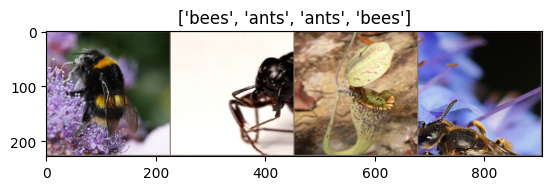

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
            
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        
        model.load_state_dict(torch.load(best_model_params_path))
    
    return model
                        

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_schduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_schduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5537 Acc: 0.7541
val Loss: 0.2603 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5022 Acc: 0.7787
val Loss: 0.2793 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.7015 Acc: 0.7336
val Loss: 0.3551 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4986 Acc: 0.7869
val Loss: 0.4898 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5267 Acc: 0.8238
val Loss: 0.6389 Acc: 0.8105

Epoch 5/24
----------
train Loss: 0.5616 Acc: 0.7787
val Loss: 0.4791 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.5333 Acc: 0.7869
val Loss: 0.2877 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3515 Acc: 0.8525
val Loss: 0.2666 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.2813 Acc: 0.8770
val Loss: 0.2365 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3310 Acc: 0.8607
val Loss: 0.2299 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2779 Acc: 0.8607
val Loss: 0.2442 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2409 Acc: 0.8893
val Loss: 0.2263 Acc: 0.9346

Ep

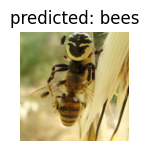

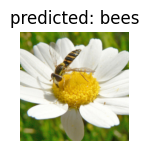

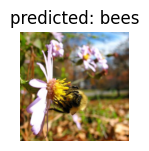

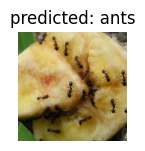

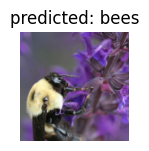

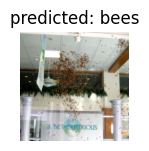

In [10]:
visualize_model(model_ft)

In [13]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_schduler, num_epochs=25)

Epoch 0/24
----------


train Loss: 0.6458 Acc: 0.6516
val Loss: 0.1969 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.5242 Acc: 0.7541
val Loss: 0.1888 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4273 Acc: 0.8279
val Loss: 0.3022 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.3914 Acc: 0.8361
val Loss: 0.1702 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4725 Acc: 0.7992
val Loss: 0.3025 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.4948 Acc: 0.7664
val Loss: 0.4017 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.5894 Acc: 0.7664
val Loss: 0.5429 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.4908 Acc: 0.8074
val Loss: 0.1688 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.4978 Acc: 0.8033
val Loss: 0.2361 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.4319 Acc: 0.8320
val Loss: 0.1797 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4951 Acc: 0.7746
val Loss: 0.2451 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3731 Acc: 0.8402
val Loss: 0.1994 Acc: 0.9477

Epoch 12/24
----------
t

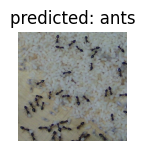

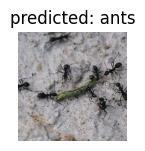

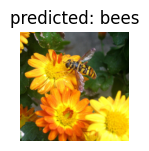

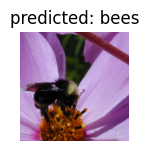

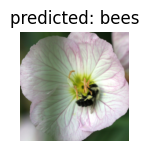

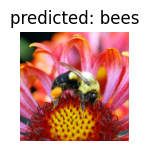

In [15]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [16]:
def visualize_model_prediction(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)
    with torch.no_grad():
        outouts = model(img)
        _, preds = torch.max(outouts, 1)
        ax = plt.subplot(2, 2, 1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
        model.train(mode=was_training)

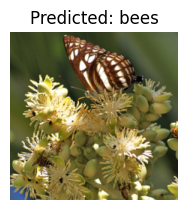

In [17]:
visualize_model_prediction(
    model_conv,
    img_path='/data/yinxiaoln/datasets/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)